# Градиент стратегии: REINFORCE.

Теорема о градиенте стратегии связывает градиент целевой функции  и градиент самой стратегии:

$$\nabla_\theta J(\theta) = \mathbb{E}_\pi [Q^\pi(s, a) \nabla_\theta \ln \pi_\theta(a \vert s)]$$

Если использовать метод Монте-Карло в качестве несмещенной оценки $Q^\pi(s, a)$ отдачу $R_t$, то тогда происходит переход к алгоритму REINFORCE и обновление весов будет осуществляться по правилу:

$$\nabla_\theta J(\theta) = [R_t \nabla_\theta \ln \pi_\theta(A_t \vert S_t)]$$

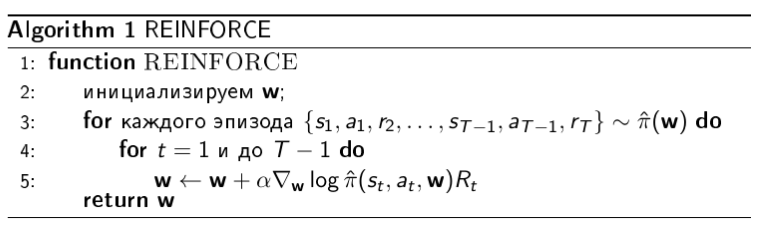

In [ ]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 13.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 2.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import gymnasium as gym
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Основной цикл

In [ ]:
def print_mean_reward(step, episode_rewards):
    if not episode_rewards:
        return

    t = min(50, len(episode_rewards))
    mean_reward = sum(episode_rewards[-t:]) / t
    print(f"step: {str(step).zfill(6)}, mean reward: {mean_reward:.2f}")
    return mean_reward


class Rollout:
    def __init__(self):
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def append(self, log_prob, reward, done):
        self.logprobs.append(log_prob)
        self.rewards.append(reward)
        self.is_terminals.append(done)


def run(env: gym.Env, hidden_size: int, lr: float, gamma: float, max_episodes: int, rollout_size: int):
    agent = ReinforceAgent(env.observation_space.shape[0], env.action_space.n, hidden_size, lr, gamma)

    step = 0
    rollout = Rollout()
    episode_returns = []

    for i_episode in range(1, max_episodes + 1):
        cumulative_reward = 0
        done = False
        state, _ = env.reset()

        while not done:
            step += 1

            action, log_prob = agent.act(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            rollout.append(log_prob, reward, done)
            cumulative_reward += reward

        episode_returns.append(cumulative_reward)

        # выполняем обновление
        if len(rollout.rewards) >= rollout_size:
            agent.update(rollout)
            mean_reward = print_mean_reward(step, episode_returns)
            if mean_reward >= 200:
                print('Принято!')
                return
            rollout = Rollout()
            episode_returns = []

In [ ]:
# Реализуйте класс, задающий стратегию агента.
# Подсказки:
#     1) подумайте, как получить на выходе из нейронной сети вероятности действий,
#     2) для выбора действия в соответствии со стратегией, можно воспользоваться `torch.distributions.Categorical`
#     3) помните, что помимо самого действия вам позже также пригодится логарифм его вероятности

class MLPModel(nn.Module):
    def __init__(self, state_dim, action_dim, hidden):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        """
        :returns: tuple (chosen action as integer, logprob of chosen action)
        """
        state = torch.from_numpy(state).float().to(device)

        ####### Здесь ваш код ########
        action_probs = self.net(state)
        dist = Categorical(action_probs)
        action = dist.sample()

        log_prob = dist.log_prob(action)
        action = action.item()
        ##############################
        return action, log_prob


class ReinforceAgent:
    def __init__(self, state_dim, action_dim, n_latent_var, lr, gamma):
        self.lr = lr
        self.gamma = gamma

        # Инициализируем стратегию агента и SGD оптимизатор
        self.policy = MLPModel(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def act(self, state):
        # Произведите выбор действия и верните кортеж (действие, логарифм вероятности этого действия)
        ####### Здесь ваш код ########
        return self.policy(state)
        ##############################

    def update(self, rollout: Rollout):
        # Конвертируем накопленный список вознаграждений в список отдач.
        # 1) обход списка делаем в обратном порядке
        # 2) не забываем сбрасывать отдачу при окончании эпизода
        rollout_len = len(rollout.rewards)
        returns = np.empty(rollout_len, dtype=float)
        ret = 0
        for i in reversed(range(rollout_len)):
            reward, is_terminal = rollout.rewards[i], rollout.is_terminals[i]
            ret = reward + (self.gamma * ret * (not is_terminal))
            returns[i] = ret

        # Выполняем нормализацию вознаграждений (отдач)
        returns = (returns - returns.mean()) / (returns.std() + 1e-7)

        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        logprobs = torch.stack(rollout.logprobs).to(device)

        # Вычислите ошибку `loss`
        # loss = ...
        ####### Здесь ваш код ########
        loss = - logprobs * returns
        loss = loss.mean()
        ##############################

        print(f'L: {loss}')

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

### Определяем гиперпараметры и запускаем обучение

In [ ]:
from gymnasium.wrappers.time_limit import TimeLimit
env_name = "CartPole-v1"

run(
    env = TimeLimit(gym.make(env_name), 500),
    max_episodes = 50000,  # количество эпизодов обучения
    hidden_size = 64,  # кол-во переменных в скрытых слоях
    rollout_size = 500,  # через столько шагов стратегия будет обновляться
    lr = 0.01, # learning rate
    gamma = 0.995,  # дисконтирующий множитель,
)

L: 0.0009461526642553508
step: 000509, mean reward: 21.21
L: 0.0034573774319142103
step: 001021, mean reward: 28.44
L: -0.005314723122864962
step: 001550, mean reward: 40.69
L: -0.0008821923984214664
step: 002074, mean reward: 74.86
L: -0.004837839864194393
step: 002611, mean reward: 67.12
L: -0.005549461115151644
step: 003166, mean reward: 69.38
L: 0.026929477229714394
step: 003716, mean reward: 110.00
L: -0.009476789273321629
step: 004231, mean reward: 128.75
L: -0.029638640582561493
step: 004765, mean reward: 133.50
L: -0.016223009675741196
step: 005269, mean reward: 126.00
L: -0.03140997141599655
step: 005815, mean reward: 136.50
L: -0.002320149214938283
step: 006474, mean reward: 164.75
L: -0.00602703308686614
step: 007096, mean reward: 311.00
Принято!


In [ ]:
env = TimeLimit(gym.make(env_name), 500)

In [ ]:
env.action_space

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Discrete(2)